In [1]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

print(torch.__version__)
print(torchaudio.__version__)

2.8.0
2.8.0


In [5]:
!pip install librosa
!pip install resampy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 47.2 MB/s  0:00:00


In [2]:
import math
import torch

DEFAULT_OFFSET = 201

def _get_log_freq(sample_rate, max_sweep_rate, offset):
    start, stop = math.log(offset), math.log(offset + max_sweep_rate // 2)
    return torch.exp(torch.linspace(start, stop, sample_rate, dtype=torch.double)) - offset

def get_sine_sweep(sample_rate, offset=DEFAULT_OFFSET):
    max_sweep_rate = sample_rate
    freq = _get_log_freq(sample_rate, max_sweep_rate, offset)
    delta = 2 * math.pi * freq / sample_rate
    cummulative = torch.cumsum(delta, dim=0)
    signal = torch.sin(cummulative).unsqueeze(dim=0)  # [1, T]
    return signal

In [7]:
import math
import timeit
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import pandas as pd
import os, glob

import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from IPython.display import Audio

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

# === (1) 스펙트로그램 도식 함수 ===
def plot_spectrogram_std(wf, sr, title):
    spec = T.Spectrogram(n_fft=1024, hop_length=256)(wf)
    spec_db = T.AmplitudeToDB()(spec).mean(dim=0)   # 채널 평균
    t_max = spec_db.shape[1] * 256 / sr
    f_max = sr / 2
    plt.figure(figsize=(10, 3))
    plt.imshow(spec_db.numpy(), origin="lower", aspect="auto",
               extent=[0, t_max, 0, f_max])
    plt.title(title); plt.xlabel("Time [s]"); plt.ylabel("Frequency [Hz]")
    plt.colorbar(label="dB"); plt.tight_layout(); plt.show()

# === (2) 폴더 내 파일 반복 ===
DATA_DIR = "./audio_dataset"
files = sorted(
    glob.glob(os.path.join(DATA_DIR, "*.m4a")) +
    glob.glob(os.path.join(DATA_DIR, "*.mp3"))
)

assert files, f"{DATA_DIR} 폴더에 오디오 파일이 없습니다."

DOWNSAMPLE_RATIO = 0.5
UPSAMPLE_RATIO   = 2.


In [8]:
for fpath in files:
    print("="*50)
    print(f"Processing: {fpath}")
    try:
        waveform, sample_rate = torchaudio.load(fpath)
    except Exception as e:
        print(f"  [!] Failed to load {fpath}: {e}")
        continue

    print(f" - shape={tuple(waveform.shape)} | sr={sample_rate}")

Processing: ./audio_dataset/095522039.m4a
  [!] Failed to load ./audio_dataset/095522039.m4a: Error opening './audio_dataset/095522039.m4a': Format not recognised.
Processing: ./audio_dataset/095522040.m4a
  [!] Failed to load ./audio_dataset/095522040.m4a: Error opening './audio_dataset/095522040.m4a': Format not recognised.
Processing: ./audio_dataset/095522041.m4a
  [!] Failed to load ./audio_dataset/095522041.m4a: Error opening './audio_dataset/095522041.m4a': Format not recognised.
Processing: ./audio_dataset/095522042.m4a
  [!] Failed to load ./audio_dataset/095522042.m4a: Error opening './audio_dataset/095522042.m4a': Format not recognised.


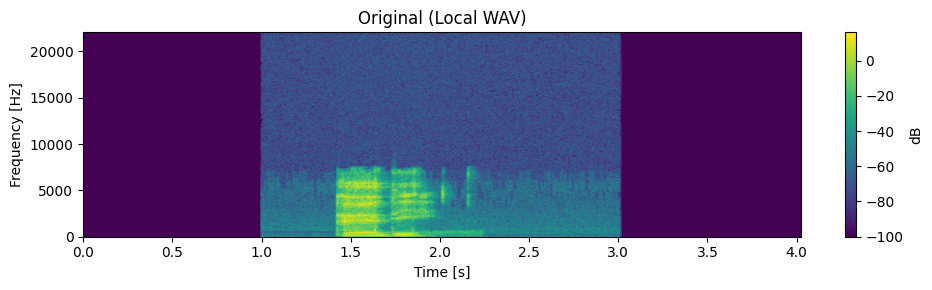

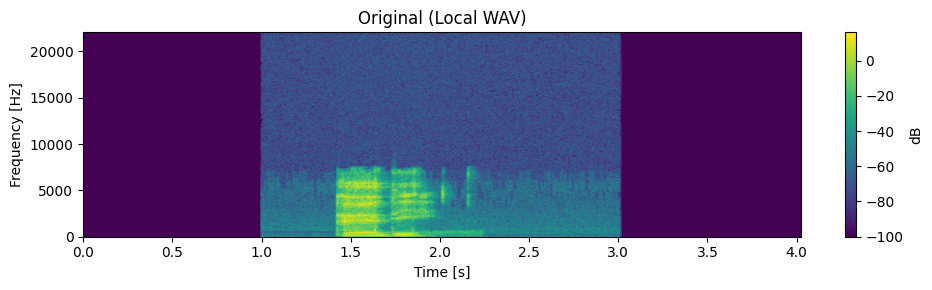

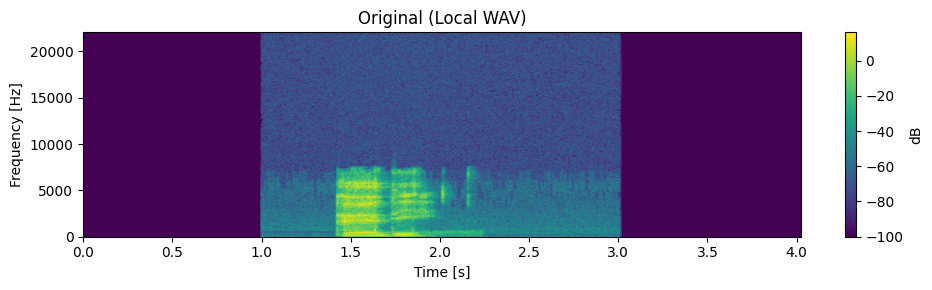

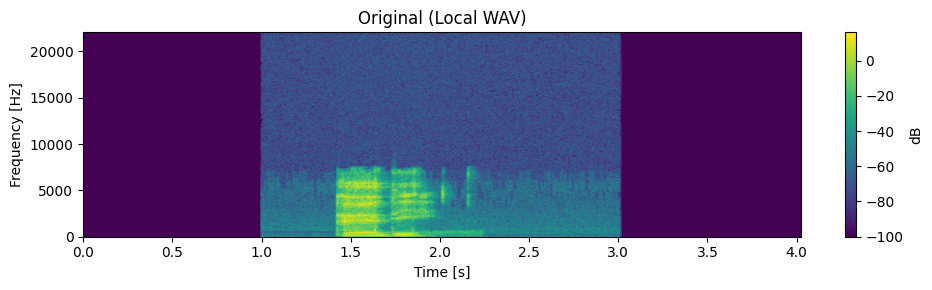

In [9]:
for fpath in files:
    plot_spectrogram_std(waveform, sample_rate, "Original (Local WAV)")
    Audio(waveform.numpy()[0], rate=sample_rate)

In [19]:
mse = torch.square(resampled_waveform - librosa_resampled_waveform).mean().item()
print("torchaudio and librosa kaiser best MSE:", mse)

torchaudio and librosa kaiser best MSE: 9.399483144947873e-13


In [25]:
mse = torch.square(resampled_waveform - librosa_resampled_waveform).mean().item()
print("torchaudio and librosa kaiser fast MSE:", mse)

torchaudio and librosa kaiser fast MSE: 9.744154268187533e-12


In [26]:
print(f"torchaudio: {torchaudio.__version__}")
print(f"librosa: {librosa.__version__}")
print(f"resampy: {resampy.__version__}")

torchaudio: 2.8.0
librosa: 0.11.0
resampy: 0.4.3


In [10]:
def benchmark_resample_functional(
    waveform,
    sample_rate,
    resample_rate,
    lowpass_filter_width=6,
    rolloff=0.99,
    resampling_method="sinc_interp_hann",
    beta=None,
    iters=5,
):
    return (
        timeit.timeit(
            stmt="""
torchaudio.functional.resample(
    waveform,
    sample_rate,
    resample_rate,
    lowpass_filter_width=lowpass_filter_width,
    rolloff=rolloff,
    resampling_method=resampling_method,
    beta=beta,
)
        """,
            setup="import torchaudio",
            number=iters,
            globals=locals(),
        )
        * 1000
        / iters
    )

In [11]:
def benchmark_resample_transforms(
    waveform,
    sample_rate,
    resample_rate,
    lowpass_filter_width=6,
    rolloff=0.99,
    resampling_method="sinc_interp_hann",
    beta=None,
    iters=5,
):
    return (
        timeit.timeit(
            stmt="resampler(waveform)",
            setup="""
import torchaudio

resampler = torchaudio.transforms.Resample(
    sample_rate,
    resample_rate,
    lowpass_filter_width=lowpass_filter_width,
    rolloff=rolloff,
    resampling_method=resampling_method,
    dtype=waveform.dtype,
    beta=beta,
)
resampler.to(waveform.device)
        """,
            number=iters,
            globals=locals(),
        )
        * 1000
        / iters
    )

In [12]:
def benchmark_resample_librosa(
    waveform,
    sample_rate,
    resample_rate,
    res_type=None,
    iters=5,
):
    waveform_np = waveform.squeeze().numpy()
    return (
        timeit.timeit(
            stmt="""
librosa.resample(
    waveform_np,
    orig_sr=sample_rate,
    target_sr=resample_rate,
    res_type=res_type,
)
        """,
            setup="import librosa",
            number=iters,
            globals=locals(),
        )
        * 1000
        / iters
    )

In [13]:
def benchmark(sample_rate, resample_rate):
    times, rows = [], []
    waveform = get_sine_sweep(sample_rate).to(torch.float32)

    args = (waveform, sample_rate, resample_rate)

    # sinc 64 zero-crossings
    f_time = benchmark_resample_functional(*args, lowpass_filter_width=64)
    t_time = benchmark_resample_transforms(*args, lowpass_filter_width=64)
    times.append([None, f_time, t_time])
    rows.append("sinc (width 64)")

    # sinc 6 zero-crossings
    f_time = benchmark_resample_functional(*args, lowpass_filter_width=16)
    t_time = benchmark_resample_transforms(*args, lowpass_filter_width=16)
    times.append([None, f_time, t_time])
    rows.append("sinc (width 16)")

    # kaiser best
    kwargs = {
        "lowpass_filter_width": 64,
        "rolloff": 0.9475937167399596,
        "resampling_method": "sinc_interp_kaiser",
        "beta": 14.769656459379492,
    }
    lib_time = benchmark_resample_librosa(*args, res_type="kaiser_best")
    f_time = benchmark_resample_functional(*args, **kwargs)
    t_time = benchmark_resample_transforms(*args, **kwargs)
    times.append([lib_time, f_time, t_time])
    rows.append("kaiser_best")

    # kaiser fast
    kwargs = {
        "lowpass_filter_width": 16,
        "rolloff": 0.85,
        "resampling_method": "sinc_interp_kaiser",
        "beta": 8.555504641634386,
    }
    lib_time = benchmark_resample_librosa(*args, res_type="kaiser_fast")
    f_time = benchmark_resample_functional(*args, **kwargs)
    t_time = benchmark_resample_transforms(*args, **kwargs)
    times.append([lib_time, f_time, t_time])
    rows.append("kaiser_fast")

    df = pd.DataFrame(times, columns=["librosa", "functional", "transforms"], index=rows)
    return df

In [14]:
def plot(df):
    print(df.round(2))
    ax = df.plot(kind="bar")
    plt.ylabel("Time Elapsed [ms]")
    plt.xticks(rotation=0, fontsize=10)
    for cont, col, color in zip(ax.containers, df.columns, mcolors.TABLEAU_COLORS):
        label = ["N/A" if v != v else str(v) for v in df[col].round(2)]
        ax.bar_label(cont, labels=label, color=color, fontweight="bold", fontsize="x-small")

                 librosa  functional  transforms
sinc (width 64)      NaN        3.18        1.67
sinc (width 16)      NaN        0.48        0.31
kaiser_best         5.74        1.03        0.63
kaiser_fast         1.70        0.37        0.22
                 librosa  functional  transforms
sinc (width 64)      NaN        0.75        0.68
sinc (width 16)      NaN        0.25        0.20
kaiser_best         4.28        0.68        0.58
kaiser_fast         1.35        0.30        0.22
                 librosa  functional  transforms
sinc (width 64)      NaN        0.68        0.72
sinc (width 16)      NaN        0.25        0.21
kaiser_best         4.37        0.64        0.56
kaiser_fast         1.32        0.33        0.28
                 librosa  functional  transforms
sinc (width 64)      NaN        0.68        0.58
sinc (width 16)      NaN        0.24        0.26
kaiser_best         4.42        0.62        0.53
kaiser_fast         1.34        0.28        0.21


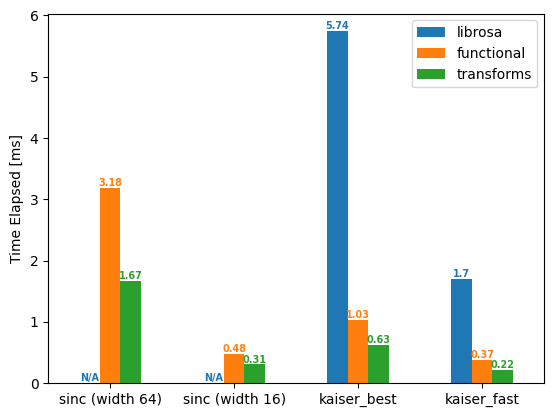

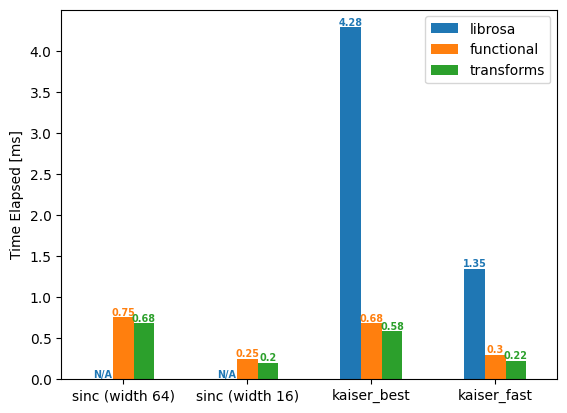

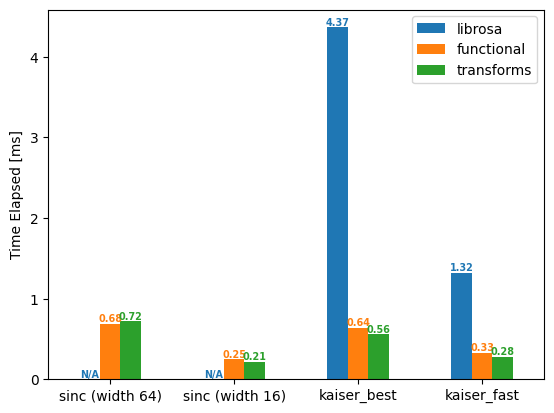

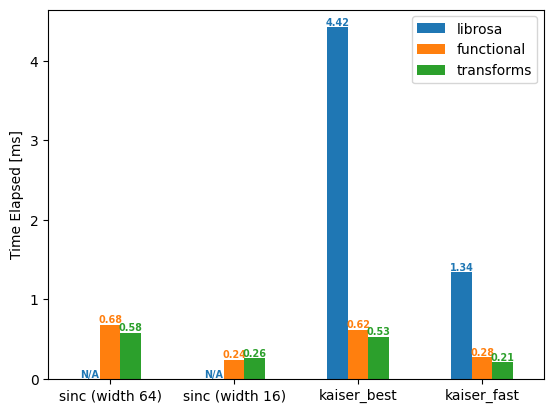

In [16]:
for fpath in files:
    df = benchmark(16_000, 8_000)
    plot(df)

                 librosa  functional  transforms
sinc (width 64)      NaN        1.83        1.65
sinc (width 16)      NaN        0.69        0.13
kaiser_best         5.07        0.49        0.30
kaiser_fast         1.48        0.24        0.18
                 librosa  functional  transforms
sinc (width 64)      NaN        0.35        0.26
sinc (width 16)      NaN        0.14        0.07
kaiser_best         4.45        0.42        0.39
kaiser_fast         1.28        0.20        0.09
                 librosa  functional  transforms
sinc (width 64)      NaN        0.30        0.25
sinc (width 16)      NaN        0.12        0.10
kaiser_best         3.85        0.31        0.32
kaiser_fast         1.22        0.16        0.08
                 librosa  functional  transforms
sinc (width 64)      NaN        0.30        0.18
sinc (width 16)      NaN        0.14        0.08
kaiser_best         3.85        0.27        0.21
kaiser_fast         1.22        0.16        0.11


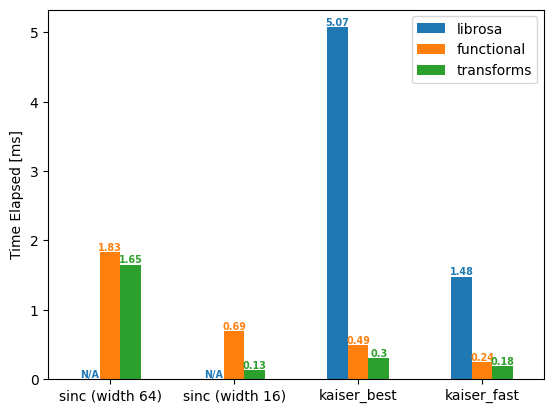

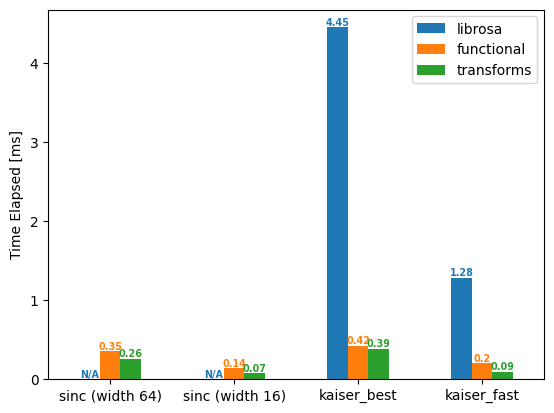

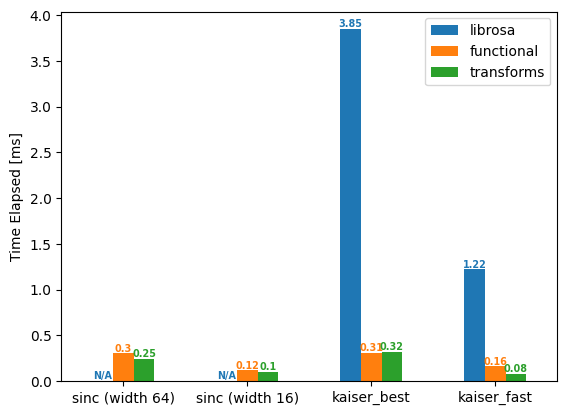

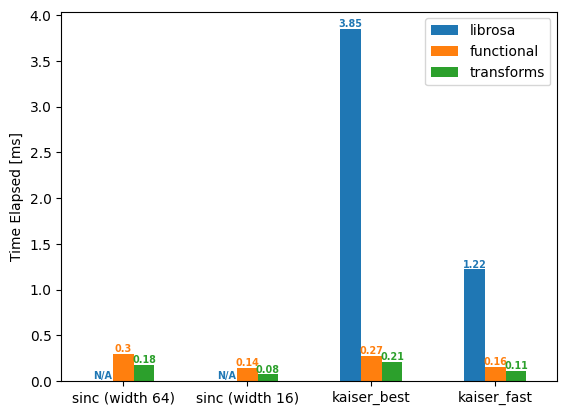

In [17]:
for fpath in files:
    df = benchmark(8_000, 16_000)
    plot(df)